# Household Carbon Footprint Analysis

The aim of this notebook is to make the invisible visible. All carbon emissions result from individual actions, but without clarity as to which actions cause which emissions it's hard to make improvements.

## Top Down Analysis

We'll start by looking at country-wide data ([Source](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1147372/2022_Provisional_emissions_statistics_report.pdf)). We'll try to use SI units where possible, e.g. kg for volumes of carbon.

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
uk_emissions_by_sector_2022 = pd.DataFrame({
    'Sector': [
        'Energy supply',
        'Business',
        'Transport',
        'Public',
        'Residential',
        'Other'
    ],
    'Emissions': [
        82.2e9,
        61.9e9,
        112.5e9,
        7.6e9,
        56.4e9,
        10.9e9
    ]
})

We're goint to work on a per-household basis. Even this is problematic - it's unlikely that a single person household produces the same emissions as a four person household, but let's stick with it for now.

<Axes: xlabel='Sector'>

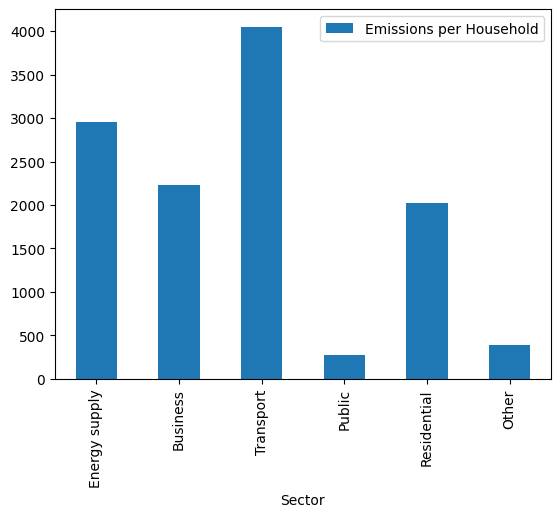

In [3]:
num_households = 27.8e6
uk_emissions_by_sector_2022['Emissions per Household'] = uk_emissions_by_sector_2022['Emissions'] / num_households
uk_emissions_by_sector_2022.plot.bar(x='Sector', y='Emissions per Household')

We can also calculate the total.

In [4]:
uk_emissions_by_sector_2022['Emissions per Household'].sum()

11924.460431654677

We're interested in understanding the composition of my household's carbon emissions. We'll use the scope 1, 2 & 3 categorisation from the GHG Protocol, i.e.

* Scope 1: Direct emissions.
* Scope 2: Directly purchased electricity, steam, heating and cooling.
* Scope 3: Indirect emissions.

## Scope 1

Scope 1 emissions for my household are natural gas consuption (used only for heating and hot water) and vehicle tailpipe emissions.

### Natural gas consumption

This is available from meter readings.

In [5]:
energy_data = pd.read_csv('energy.csv')

# https://www.carbonindependent.org/15.html
# https://electricityproduction.uk/carbon-intensity/?t=10y

energy_data['gas_kg_co2_per_year'] = energy_data['Gas (kWh)'] * 0.185 * 12
energy_data['electricity_kg_co2_per_year'] = energy_data['Electricity (kWh)'] * 0.250 * 12

energy_data['Unnamed: 0'] = pd.to_datetime(energy_data['Unnamed: 0'])
energy_data.rename(columns={'Unnamed: 0': 'Month'}, inplace=True)

/tmp/ipykernel_59738/2841756764.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  energy_data['Unnamed: 0'] = pd.to_datetime(energy_data['Unnamed: 0'])


We'll use the date range July 2022 to June 2023 for this analysis, as it's where we have the most complete data. Averaging over the period gives

In [6]:
energy_data[
    (energy_data['Month'] >= datetime.datetime(2022,7,1))
    & (energy_data['Month'] < datetime.datetime(2023,7,1))
]['gas_kg_co2_per_year'].mean()

1801.7427499999997

This is close to the figure derived from national data.

### Vehicle emissions

This is available from records of fuel purchases, although it requires a bit more processing

In [7]:
fuel_data = pd.read_csv('fuel.csv')

fuel_data = fuel_data[['Unnamed: 0', 'Volume (l)', 'Milage']].rename(columns={
    'Unnamed: 0': 'date',
    'Volume (l)': 'litres',
    'Milage': 'miles'
})
fuel_data['date'] = pd.to_datetime(fuel_data['date'])
fuel_data['start_date'] = fuel_data['date'].shift()
fuel_data['days'] = fuel_data['date'].diff().apply(lambda x: x.days)
fuel_data = fuel_data.dropna(subset = ['start_date', 'days'])
fuel_data['litres_per_day'] = fuel_data['litres'] / fuel_data['days']

#data = fuel_data['litres_per_day']
#widths = fuel_data['date'] - fuel_data['start_date']
#left = fuel_data['start_date']
#plt.bar(left, data, width = widths, 
#alpha = 0.6, align='edge', edgecolor = 'k', linewidth = 0)

def divide_into_month(
  x,
  month,
  start_month,
  end_month,
  start_days_missed,
  end_days_missed,
  total_days   
):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days = days_in_month[month % 12]
    if month == start_month:
        days -= start_days_missed
    if month == end_month:
        days -= end_days_missed
    return days * x / total_days

def divide_by_month(x, start_date, end_date):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    start_month = (start_date.year - 2000) * 12 + start_date.month - 1
    end_month = (end_date.year - 2000) * 12 + end_date.month - 1
    start_days_missed = (start_date.day - 1)
    end_days_missed = days_in_month[end_date.month - 1] - end_date.day
    total_days = (end_date - start_date).days
    return pd.DataFrame([
        {
            'month': month,
            'litres': divide_into_month(
                x,
                month,
                start_month,
                end_month,
                start_days_missed,
                end_days_missed,
                total_days
            )
        }
        for month in range(start_month, end_month + 1)
    ])

fuel_by_month = pd.concat([divide_by_month(row['litres'], row['start_date'], row['date']) for index, row in fuel_data.iterrows()]).groupby('month').agg({
    'litres': 'sum'
}).reset_index()
fuel_by_month['date'] = fuel_by_month['month'].apply(lambda x: datetime.date(x // 12 + 2000, x % 12 + 1, 1))
#fuel_by_month.plot.bar(x='date', y='litres')

fuel_by_month['kg_co2_per_year'] = fuel_by_month['litres'] * 2.3035 * 12

In [8]:
fuel_by_month

,month,litres,date,kg_co2_per_year
0,267,12.523529,2022-04-01,346.175400
1,268,120.356176,2022-05-01,3326.885430
2,269,112.266833,2022-06-01,3103.279807
3,270,55.441607,2022-07-01,1532.516905
4,271,62.518127,2022-08-01,1728.126066
5,272,82.221544,2022-09-01,2272.767915
6,273,118.159963,2022-10-01,3266.177710
7,274,103.006429,2022-11-01,2847.303699
8,275,106.349881,2022-12-01,2939.723409
9,276,96.138312,2023-01-01,2657.455212


We can now calculate a total for the period being analysed.

In [9]:
fuel_by_month[
    (fuel_by_month['date'] >= datetime.date(2022,7,1))
    & (fuel_by_month['date'] < datetime.date(2023,7,1))
]['kg_co2_per_year'].mean()

2453.52702334167

This is substantially below the 'transport' category in the national data, but domestic vehicle use doesn't account for the whole of the category.

## Scope 2
### Electricity consuption

This was already calculated above.

In [10]:
energy_data[
    (energy_data['Month'] >= datetime.datetime(2022,7,1))
    & (energy_data['Month'] < datetime.datetime(2023,7,1))
]['electricity_kg_co2_per_year'].mean()

886.475

This is substantially lower than the 'energy supply' category in the national data, which we'll investigate later.

## Scope 3

We'll use national averages for now, but will first need to estimate double counting so it can be removed. Ntural gas consuption replaces the 'residential' category in the national data.

Electricity data is available [here](https://www.gov.uk/government/statistics/energy-consumption-in-the-uk-2022). The fraction of electricity consumed domestically is given by

In [11]:
9411/24577

0.38291898929893803

This corresponds to per household emissions of

In [12]:
(82.2e9 * 9411)/(24577 * num_households)

1132.2280906608887

and residual non-domestic emissions of

In [13]:
(82.2e9 * 1 - (9411/24577)) / num_households

2956.8345323603266

Vehicle emissions are more complex. [This data](https://www.gov.uk/government/statistics/transport-and-environment-statistics-2022/transport-and-environment-statistics-2022) gives the percentage of emissions by cars and taxis as

In [14]:
52 / (52 + 19 + 16 + 5 + 2 + 5)

0.5252525252525253

[This data](https://www.gov.uk/government/statistics/transport-statistics-great-britain-2022/transport-statistics-great-britain-2022-domestic-travel) says that about 15% of trips are for commuting or business. Domestic car usage therefore accounts for

In [15]:
(112.5e9 * (52 / (52 + 19 + 16 + 5 + 2 + 5)) * (1-0.15)) / num_households

1806.7364290385874

Residual transport emissions are

In [16]:
(112.5e9 * (1 - (52 / (52 + 19 + 16 + 5 + 2 + 5)) * (1-0.15))) / num_households

2240.0261608894702

Total scope 3 emissions are therefore

In [17]:
(2956.8345323603266 # Residual energy
+ 61.9e9 / num_households # Business
+ 2240.0261608894702 # Residual transport
+ 7.6e9 / num_households # Public
+ 0 # Residential
+ 10.9e9 / num_households # Other
+ 1900 + 2400 + 2600 + 2300) # Flights (Barcelona, Naples, Malaga, Miami)

17288.94702418505

In [18]:
61.9e9 / num_households

2226.6187050359713

In [19]:
7.6e9 / num_households

273.38129496402877

In [20]:
10.9e9 / num_households

392.0863309352518

## Summary

<Axes: xlabel='Scope'>

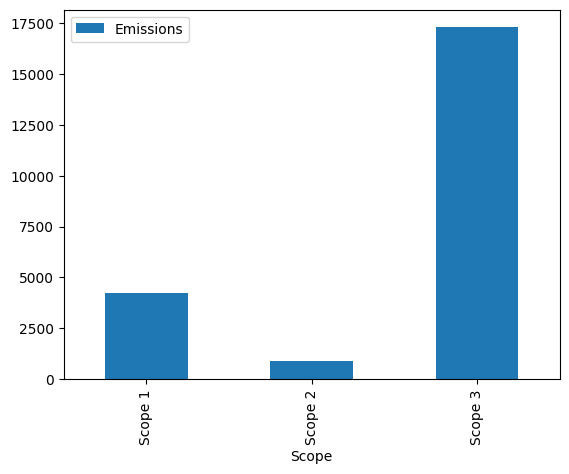

In [21]:
pd.DataFrame({
    'Scope': ['Scope 1', 'Scope 2', 'Scope 3'],
    'Emissions': [1801.7427499999997 + 2453.52702334167, 886.475,  17288.94702418505],
}).plot.bar(x='Scope', y='Emissions')

In [22]:
5.17*4*365 # food - https://www.wwf.org.uk/sites/default/files/2018-03/Food_in_a_warming_world_report.PDF

7548.2

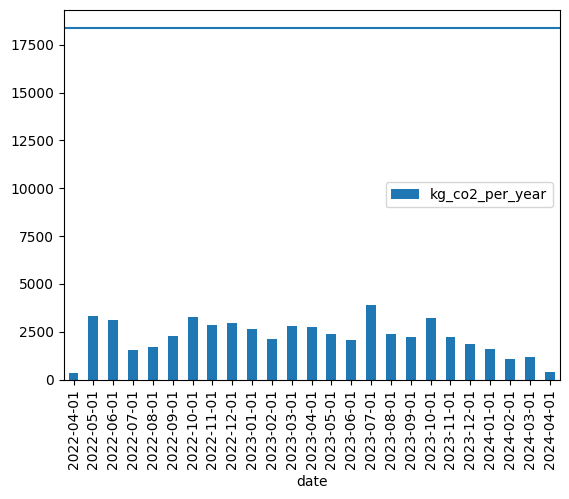

In [23]:
ax = fuel_by_month.plot.bar(x='date', y='kg_co2_per_year')
ax.axhline(4600*4)

In [24]:
fuel_data['grammes_co2_per_day'] = fuel_data['litres_per_day'] * 2303.5

In [25]:
5000 * 365

1825000

In [26]:
litres_per_kilometer = fuel_data.dropna()['litres'].sum() / (fuel_data.dropna()['miles'].sum() * 1.609)
kilometers_for_nursery = 4.5 * 8 * 52
litres_for_nursery_per_day = kilometers_for_nursery * litres_per_kilometer / 365
grammes_co2_for_nursery_per_day = litres_for_nursery_per_day * 2303.5
grammes_co2_for_nursery_per_day

1227.4680455923979

In [27]:
kilometers_for_gym = 4.83 * 5 * 52
litres_for_gym_per_day = kilometers_for_gym * litres_per_kilometer / 365
grammes_co2_for_gym_per_day = litres_for_gym_per_day * 2303.5
grammes_co2_for_gym_per_day

823.4264805849002

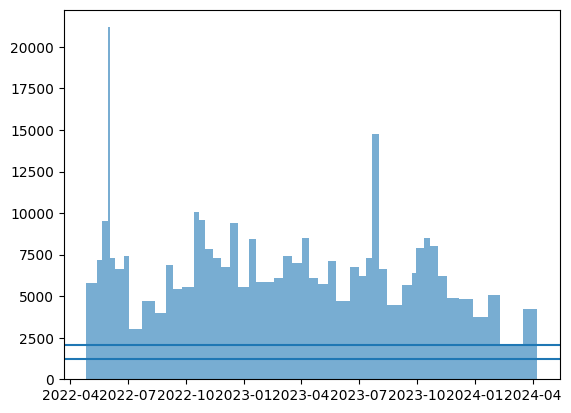

In [28]:
data = fuel_data['grammes_co2_per_day']
widths = fuel_data['date'] - fuel_data['start_date']
left = fuel_data['start_date']
ax = plt.bar(left, data, width = widths, 
alpha = 0.6, align='edge', edgecolor = 'k', linewidth = 0)
plt.axhline(grammes_co2_for_nursery_per_day)
plt.axhline(grammes_co2_for_nursery_per_day + grammes_co2_for_gym_per_day)

In [29]:
(grammes_co2_for_nursery_per_day + grammes_co2_for_gym_per_day) * 365

748576.5020547137

In [30]:
300 / 10000

0.03

In [31]:
26.5 * litres_per_kilometer * 2303.5 / 14

453.0175774951339

## Gas and Electricity

In [32]:
fuel_by_month['date'] = pd.to_datetime(fuel_by_month['date'])

In [33]:
fuel_by_month

,month,litres,date,kg_co2_per_year
0,267,12.523529,2022-04-01,346.175400
1,268,120.356176,2022-05-01,3326.885430
2,269,112.266833,2022-06-01,3103.279807
3,270,55.441607,2022-07-01,1532.516905
4,271,62.518127,2022-08-01,1728.126066
5,272,82.221544,2022-09-01,2272.767915
6,273,118.159963,2022-10-01,3266.177710
7,274,103.006429,2022-11-01,2847.303699
8,275,106.349881,2022-12-01,2939.723409
9,276,96.138312,2023-01-01,2657.455212


In [34]:
flight_lhr_ebb = 9100
flight_stn_bcn = 2700
flight_stn_nap = 2400
flight_stn_agp = 2600
flight_lhr_mia = 2300
flight_lgw_tfs = 4000
fuel_by_month['Flights'] = [flight_lhr_ebb + flight_stn_bcn + flight_stn_nap] * 9 + [flight_stn_agp + flight_lhr_mia] * 12 + [flight_lgw_tfs] * 4

In [35]:
combined = fuel_by_month.merge(energy_data, left_on='date', right_on='Month').rename(columns={
    'kg_co2_per_year': 'Vehicle fuel',
    'gas_kg_co2_per_year': 'Domestic natural gas (heating and hot water)',
    'electricity_kg_co2_per_year': 'Domestic electricity',
})

In [36]:
combined

,month,litres,date,Vehicle fuel,Flights,Month,Gas (kWh),Electricity (kWh),Domestic natural gas (heating and hot water),Domestic electricity
0,267,12.523529,2022-04-01,346.175400,14200,2022-04-01,412.96,202.2,916.7712,606.6
1,268,120.356176,2022-05-01,3326.885430,14200,2022-05-01,322.92,326.4,716.8824,979.2
2,269,112.266833,2022-06-01,3103.279807,14200,2022-06-01,260.65,316.6,578.6430,949.8
3,270,55.441607,2022-07-01,1532.516905,14200,2022-07-01,199.40,290.8,442.6680,872.4
4,271,62.518127,2022-08-01,1728.126066,14200,2022-08-01,232.90,256.5,517.0380,769.5
5,272,82.221544,2022-09-01,2272.767915,14200,2022-09-01,297.76,303.3,661.0272,909.9
6,273,118.159963,2022-10-01,3266.177710,14200,2022-10-01,283.22,308.1,628.7484,924.3
7,274,103.006429,2022-11-01,2847.303699,14200,2022-11-01,934.71,305.1,2075.0562,915.3
8,275,106.349881,2022-12-01,2939.723409,14200,2022-12-01,1954.03,322.0,4337.9466,966.0
9,276,96.138312,2023-01-01,2657.455212,4900,2023-01-01,1716.18,326.3,3809.9196,978.9


In [37]:
population = 67.7e6
food = 5.17 * 365 * population / num_households
combined['Food'] = food

combined['Other Scope 3'] = (2956.8345323603266 # Residual energy
+ 61.9e9 / num_households # Business
+ 2240.0261608894702 # Residual transport
+ 7.6e9 / num_households # Public
+ 0 # Residential
+ 10.9e9 / num_households # Other
-food)

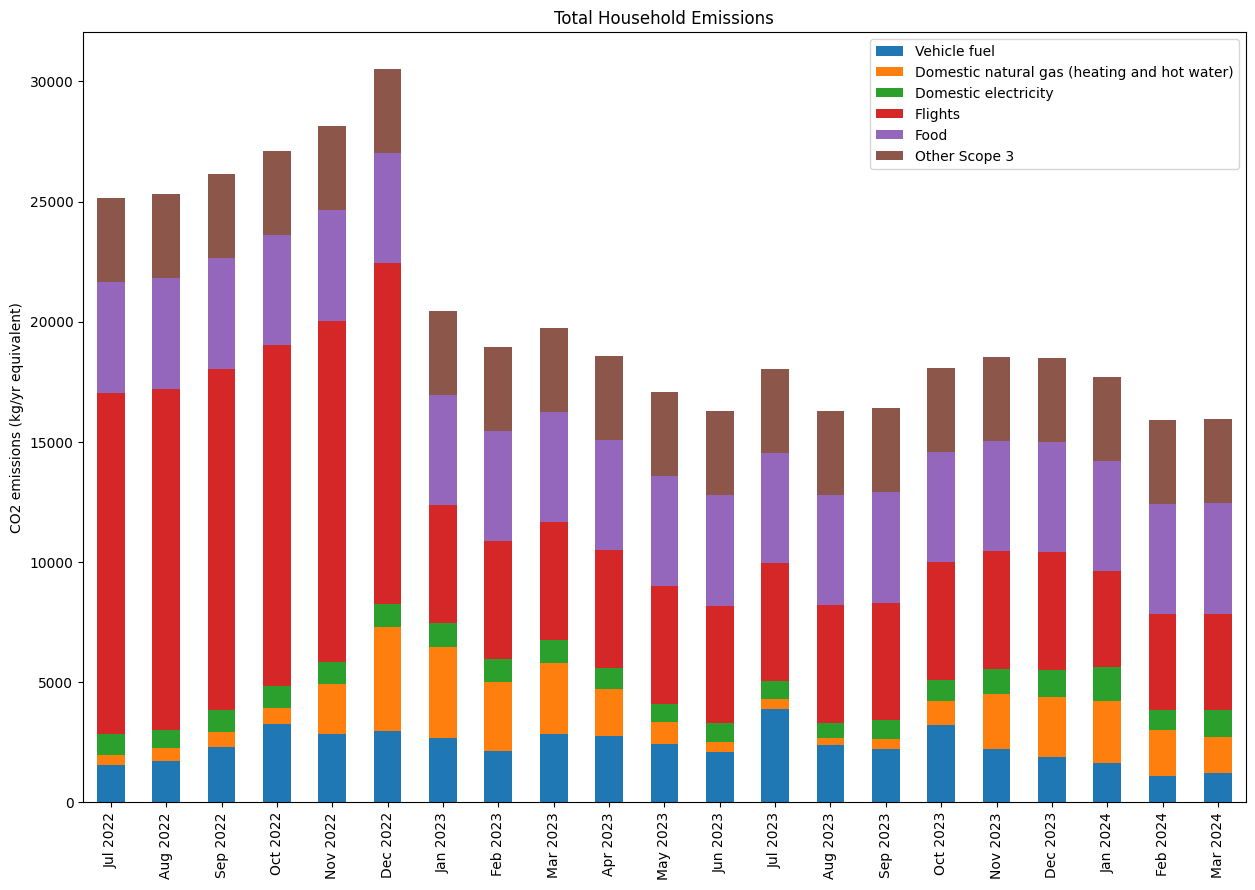

In [38]:
df = combined[combined['date'] > datetime.datetime(2022,6,1)]
ax = df.plot.bar(figsize=(15,10), x='date', y=['Vehicle fuel', 'Domestic natural gas (heating and hot water)', 'Domestic electricity', 'Flights', 'Food', 'Other Scope 3'], stacked=True)
x_labels = df['date'].apply(lambda x: x.strftime('%b %Y'))
ax.set_xticklabels(x_labels)
ax.set_xlabel(None)
ax.set_ylabel('CO2 emissions (kg/yr equivalent)')
#ax.axhline(24100, c='r', ls=':')
ax.set_title('Total Household Emissions')
plt.savefig('/tmp/total_emissions.png', transparent=False, facecolor='white')

In [39]:
df['Vehicle fuel'].mean()

2338.307834756011

In [40]:
df['Domestic natural gas (heating and hot water)'].min()

303.67379999999997

In [41]:
df['Domestic natural gas (heating and hot water)'].max()

4337.946599999999

## Analysis of other sectors

Data from https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1147372/2022_Provisional_emissions_statistics_report.pdf